# Data visualization of world contraceptive use

In [1]:
import geopandas 
import pandas as pd
import seaborn as sns
import numpy as np
import pycountry # used to identify country code
from fuzzywuzzy import fuzz # used to fuzzy merge data
from fuzzywuzzy import process # used to fuzzy merge data
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from bokeh.palettes import Spectral6 ## used to create interactive plot
from bokeh.plotting import figure,  show ## used to create interactive plot
from bokeh.io import output_notebook ## used to create interactive plot
from bokeh.models import Legend, ColumnDataSource, HoverTool ## used to create interactive plot
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# The data used for mapping canvas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres')) 

In [3]:
# loading contraceptive data
with pd.ExcelFile('Contraceptive_2019.xls') as xls:
    country2019 = pd.read_excel(xls, 'Sheet1', na_values= ["."])
    area2019 = pd.read_excel(xls, 'Sheet2',na_values= ["."])
    country_trend= pd.read_excel(xls, "Sheet3",na_values= ["."])

## Merge data

In [4]:
# The contraceptive data do not contain a col of unique identifiers.
# Use fuzzy merge to join two datasets.
def fuzzy_merge(data1, data2, key1, key2, threshold=95, limit=1):
    
    s = data2[key2].tolist()

    m = data1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    data1['matches'] = m

    m2 = data1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    data1['matches'] = m2

    return data1

In [5]:
match=fuzzy_merge(world, country2019, 'name', 'area')

In [6]:
#match.loc[match['matches'] == ""] ## display countries that have no matches from contraceptive data

In [7]:
World_con = pd.merge(match, country2019, 
                        left_on='matches', 
                        right_on='area',
                        how = 'left'
                       )

In [8]:
# Clean the data 
World_con=World_con[World_con.columns.drop('matches')];
World_con=World_con[World_con.columns.drop('area')]
World_con=World_con[World_con.continent!='Antarctica']

In [9]:
# a quick inspection of the data 
round(World_con.describe(), 2)

,pop_est,gdp_md_est,Any method,Female sterilisation,Male sterilisation,Pill,Injectable,Implant,IUD,Male condom,Rhythm,Withdrawal,Other methods,women(15-49 in thousands),region
count,1.760000e+02,176.00,148.00,136.00,136.00,136.00,136.00,136.00,136.00,136.00,136.00,136.00,136.00,148.00,148.0
mean,4.194935e+07,670681.31,41.33,4.60,0.61,9.80,5.35,1.49,5.16,8.30,1.71,2.64,1.08,11764.28,0.0
std,1.463514e+08,2295416.80,16.16,6.69,1.55,8.88,6.20,2.44,7.32,8.15,1.73,4.06,1.14,41438.57,0.0
min,1.400000e+02,16.00,6.50,0.00,0.00,0.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,72.00,0.0
25%,3.408326e+06,25945.00,28.98,0.50,0.00,3.08,0.40,0.10,0.70,1.70,0.50,0.40,0.38,1133.00,0.0
50%,1.010473e+07,85045.00,42.40,1.85,0.10,6.25,2.90,0.35,2.05,5.25,1.15,1.20,0.80,2611.00,0.0
75%,2.947544e+07,411950.00,53.92,4.93,0.20,13.55,7.98,1.83,7.30,12.12,2.30,2.95,1.30,8487.00,0.0
max,1.379303e+09,21140000.00,78.00,30.60,9.50,34.40,23.40,14.90,47.00,34.90,9.50,24.50,8.80,354103.00,0.0


## Contraceptive prevalence in the world
### General trend 
#### A world map to show the estimated prevalence of contraceptive use among women of reproductive age

Text(0.1, 0.28, 'Source: United  Nations, Population  Division  (2019).')

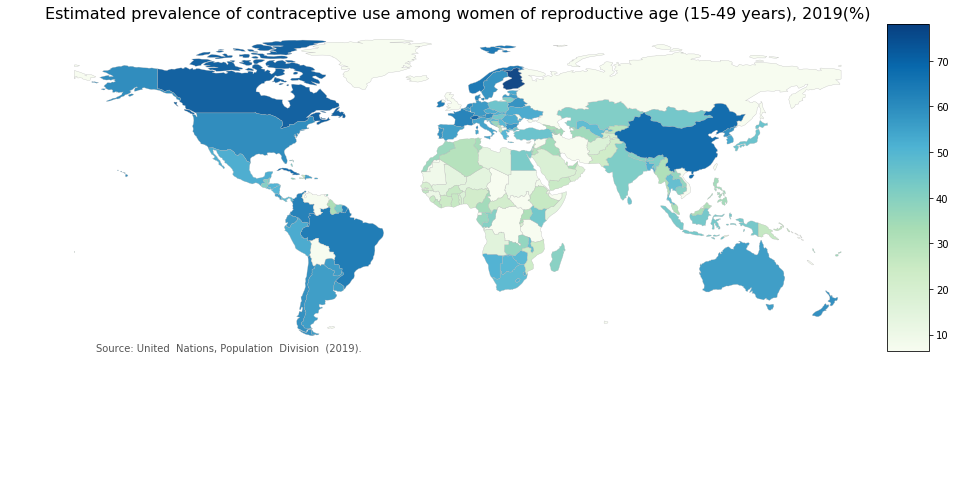

In [10]:
fig, ax = plt.subplots(1, figsize=(16, 17))
divider = make_axes_locatable(ax) # align the legend to the plot
cax = divider.append_axes("right", size="5%", pad=0.1)
World_con.plot(column='Any method', linewidth=0.3, ax=ax, edgecolor='0.7',alpha=0.95,\
               cax=cax, cmap='GnBu',legend= True)
ax.axis('off')# remove the axis
# add plot title and annotation
ax.set_title('Estimated prevalence of contraceptive use among women of reproductive age (15-49 years), 2019(%)',
             fontdict={'fontsize': '16', 'fontweight' : '5','horizontalalignment': 'center'})
ax.annotate('Source: United  Nations, Population  Division  (2019).',xy=(0.1, 0.28),  
            xycoords='figure fraction', horizontalalignment='left', verticalalignment='top',
            fontsize=10, color='#555555')


#### Contraceptive use prevalence among women in geographic regions

In [11]:
g_contra=area2019.iloc[1:9,:2]
g_contra=g_contra.sort_values("Any method", ascending=False)

Text(0.5, 0.98, 'Contraceptive use prevalence in geographic regions: all method (%)')

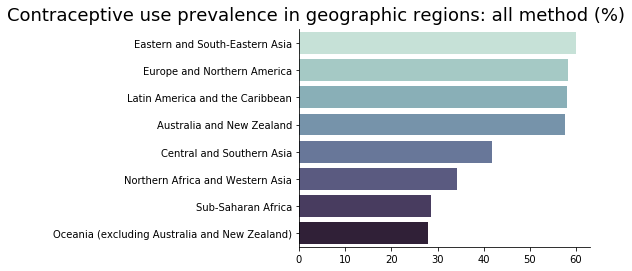

In [12]:
g=sns.catplot(y="area", x="Any method",
              palette=(sns.cubehelix_palette(8, start=.5, rot=-.5)), 
              height=4,aspect=2, kind="bar",  data=g_contra)

(g.set_ylabels("")
  .set_xlabels(""))
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Contraceptive use prevalence in geographic regions: all method (%)', 
               fontsize=18)

#### Contraceptive use prevalence among women by income levels

In [13]:
inc_contra=area2019.iloc[16:21,[0,1,2,3,4,7,8]]

In [14]:
inc_contra

,area,Any method,Female sterilisation,Male sterilisation,Pill,IUD,Male condom
16,High-income countries,56.6,6.1,3.0,17.2,6.5,14.8
17,Middle-income countries,49.6,13.8,0.6,6.7,9.4,9.9
18,Upper-middle-income countries,61.0,12.6,1.0,7.3,16.3,16.6
19,Lower-middle-income countries,40.1,14.8,0.2,6.3,3.6,4.4
20,Low-income countries,28.0,1.7,0.3,3.8,3.0,2.9


Text(0.5, 0.98, 'Contraceptive use prevalence among women by income levels(%)')

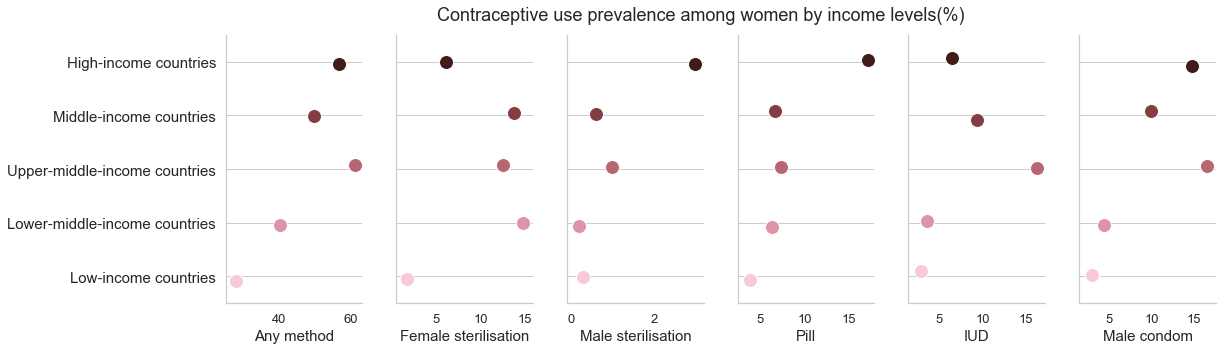

In [15]:
sns.set(style="whitegrid",rc={'font.size': 15, 'axes.labelsize': 15, 'legend.fontsize': 15, 
   'axes.titlesize': 15, 'xtick.labelsize': 13, 'ytick.labelsize': 15})
inc= sns.PairGrid(inc_contra,
                 x_vars=inc_contra.columns[1:7], y_vars=["area"],
                 height=5, aspect=.5)
inc.map(sns.stripplot, size=14, orient="h",
      palette="ch:s=1,r=-.1,h=1_r", linewidth=1, edgecolor="w")
inc.set(ylabel="")
for ax in inc.axes.flat:
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
inc.fig.subplots_adjust(top=0.9) ## title position
inc.fig.suptitle('Contraceptive use prevalence among women by income levels(%)', fontsize=18)

### Country specific trend

In [16]:
## Select 12 countries to see specific trend
countryname=[]
for i in ['USA', 'CAN', 'GBR','FRA','DEU','MEX' ,'JPN','KOR','CHN','IND','AUS','TUR']: 
    name=pycountry.countries.get(alpha_3=i).numeric
    countryname.append(int(name))
subcountry=country_trend.loc[country_trend['ISO code'].isin(countryname),\
                             ['ISO code','area', 'Survey\nend year','Any method','Female\nsterilization',\
                              'Pill', 'Male condom'] ]

In [17]:
subcountry = subcountry.rename(columns = {'ISO code':'iso','Survey\nend year':'year','Any method':'Any method' ,\
                                          'Female\nsterilization':'Female sterilization', \
                                          'Pill':'Pill', 'Male condom': 'Male condom'})


In [18]:
round(pd.pivot_table(subcountry, values=['Any method','Female sterilization','Pill','Male condom'], 
               index=['area'],aggfunc=np.mean),2)

,Any method,Female sterilization,Male condom,Pill
area,,,,
Australia,67.91,11.07,12.63,22.58
Canada,77.36,19.04,20.32,21.22
China,80.71,27.76,6.51,2.77
France,76.27,5.49,6.35,33.78
Germany,69.04,7.57,6.49,39.06
India,45.60,30.22,4.29,2.26
Japan,50.26,2.73,37.52,1.04
Mexico,58.74,20.37,3.54,9.10
Republic of Korea,62.99,16.81,10.22,3.66


In [19]:
## Only examine the trend since 1980
subcountry = subcountry.query('year>1979')
long_subc = pd.melt(subcountry, id_vars=['area','iso', 'year'],\
                    value_vars=['Any method','Female sterilization','Pill','Male condom'])
                          

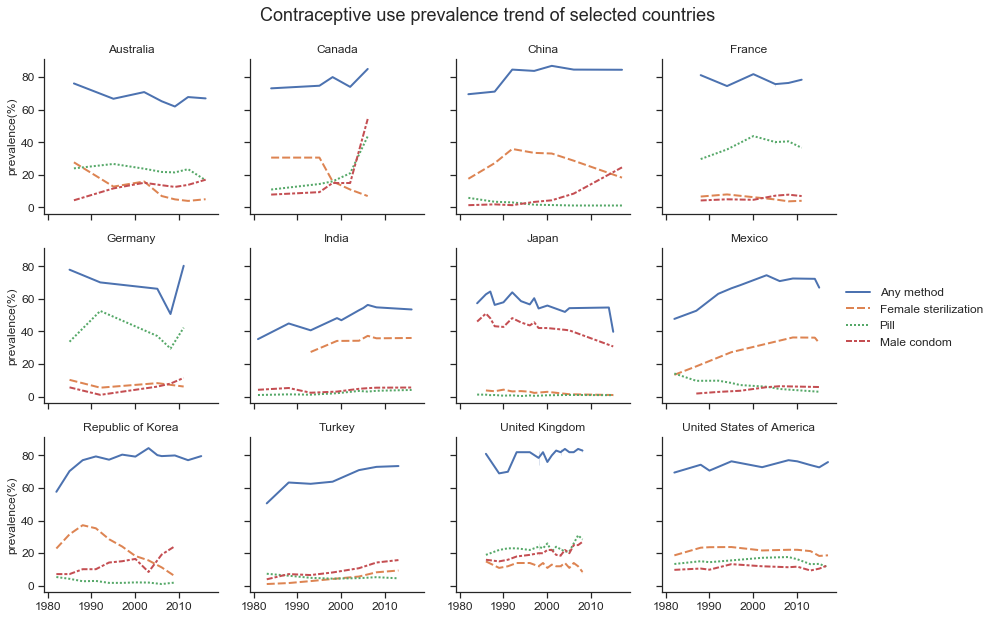

In [20]:
sns.set(style="ticks",rc={"lines.linewidth": 2,'xtick.labelsize': 12, 'ytick.labelsize': 12,\
                          'font.size': 15, 'axes.labelsize': 12, 'legend.fontsize': 12})

g=sns.relplot(x="year", y="value",
            hue="variable", 
            kind="line",col="area",style="variable", col_wrap=4, height=3,data=long_subc)
(g.set_ylabels("prevalence(%)")
  .set_xlabels(""))
g._legend.texts[0].set_text("") ## remove legend title 
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Contraceptive use prevalence trend of selected countries', fontsize=18)
# change column titles for each plot.
name=list(set(subcountry['area']))
titles=sorted(name)
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)


### Contraceptive Trend of the United States (an interactive plot)

In [21]:
## select usa data 
CODE=int(pycountry.countries.get(alpha_3='USA').numeric)
usa=country_trend.loc[country_trend['ISO code']== CODE]

In [22]:
## prepare data for plotting
usa_trend = usa.iloc[:,[3,7,8,9,12,13,21]]
usa_trend = usa_trend.rename(columns = {'Survey\nend year':'year','Female\nsterilization':'Female sterilization',
                                        'Male\nsterilization':'Male sterilization'})
usa_trend=usa_trend.interpolate(method ='linear') # fill NaN use interpolate method

In [23]:
source = ColumnDataSource(usa_trend)

p = figure(plot_width=850, plot_height=450, x_axis_label='Year', y_axis_label='prevalence (%)')
p.title.text = 'Contraceptive prevalence in the United States: 1955-2017'



for method,  color in zip(list(usa_trend.columns)[1:],  Spectral6) :
    plt=p.line(usa_trend['year'], usa_trend[method],  line_width=2, color=color, alpha=0.6,
             muted_color=color, muted_alpha=0.1, legend= method)
    p.circle(usa_trend['year'], usa_trend[method], size=5, color=color, alpha=0.6,
            muted_color=color, muted_alpha=0.1, legend= method)
    ## the hovertool is not working properly
    p.add_tools(HoverTool(renderers=[plt], tooltips=[("year","@year"), 
                                                     ("method","@usa_trend[method]")],
                                                     mode='vline'))

p.legend.location = "top_left"
p.legend.click_policy="mute"


p.legend.glyph_height = 10
p.legend.glyph_width = 7
p.legend.label_text_font_size ='8pt'

output_notebook()



show(p)     


Loading BokehJS ...